In [214]:
import glob
import os
import sys

sys.path.insert(0, "..")

import pickle as pkl
import time
from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch_geometric
from sklearn.metrics import auc, roc_curve
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataListLoader, DataLoader

import awkward as ak
import fastjet
import vector

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

from tqdm.notebook import tqdm

%matplotlib inline

# Top tagging dataset

In [101]:
! ls toptagging/*/processed

toptagging/test/processed:
data_0.pt     data_1.pt     data_2.pt     data_3.pt     data_quick.pt

toptagging/train/processed:
data_0.pt  data_10.pt data_2.pt  data_4.pt  data_6.pt  data_8.pt
data_1.pt  data_11.pt data_3.pt  data_5.pt  data_7.pt  data_9.pt

toptagging/val/processed:
data_0.pt data_1.pt data_2.pt data_3.pt


In [102]:
# load the datafiles
def load_data(dataset_path, flag, n_files=-1):
    data_files = glob.glob(f"{dataset_path}/{flag}/processed/*")
        
    data = []
    for i, file in enumerate(data_files):
        data += torch.load(f"{dataset_path}/{flag}/processed/data_{i}.pt")
        print(f"--- loaded file {i} from `{flag}` directory")
        if n_files!=-1 and i==n_files-1:
            break
                
    return data

dataset_path = "toptagging/"

data_train = load_data(dataset_path, "train", n_files=1)
# data_valid = load_data(dataset_path, "val", n_files=4)
# data_test = load_data(dataset_path, "val", n_files=4)

--- loaded file 0 from `train` directory


In [103]:
# number of jets
len(data_train)

100001

In [104]:
# check 10 samples (y=0 is QCD jet, and y=1 is a top quark jet)
data_train[:10]

[Data(x=[23, 7], y=0),
 Data(x=[43, 7], y=0),
 Data(x=[41, 7], y=0),
 Data(x=[25, 7], y=0),
 Data(x=[73, 7], y=0),
 Data(x=[55, 7], y=0),
 Data(x=[53, 7], y=0),
 Data(x=[70, 7], y=0),
 Data(x=[27, 7], y=0),
 Data(x=[64, 7], y=0)]

In [338]:
"""
The 7 input features per particle in the jet.
    1. ∆η difference in pseudorapidity between the particle and the jet axis
    2. ∆φ difference in azimuthal angle between the particle and the jet axis
    3. log pT logarithm of the particle’s pT
    4. log E logarithm of the particle’s energy
    5. log pT/pT_jet logarithm of the particle’s pT relative to the jet pT
    6. log E/E_jet logarithm of the particle’s energy relative to the jet energy
    7. ∆R
"""

feature_dict = {
    "eta": 0,
    "phi": 1,
    "pt": 2,
    "E": 3,
    "pt/jet_pt": 4,
    "E/jet_E": 5,
    "deltaR": 6,    
}

feature_label = {
    "eta": r"Particle $\left| \eta \right|$",
    "phi": r"Particle $\left| \phi \right|$",
    "pt": r"Particle $p_T$",
    "E": "Particle E",
    "pt/jet_pt": r"Log($\frac{p_T(particle)}{p_T(jet)})$",
    "E/jet_E": r"$Log(\frac{E(particle)}{E(jet)})$",
    "deltaR": r"$\Delta R(particle, jet)$", 
    
}

In [157]:
num_features = 7

# Data exploration

In [107]:
# check particle multiplicity for top quark jets vs qcd jets
multiplicity = {}
multiplicity["top"] = []
multiplicity["qcd"] = []

for jet in data_train:
    if jet.y==1:
        multiplicity["top"].append(len(jet.x))
    else:
        multiplicity["qcd"].append(len(jet.x))        

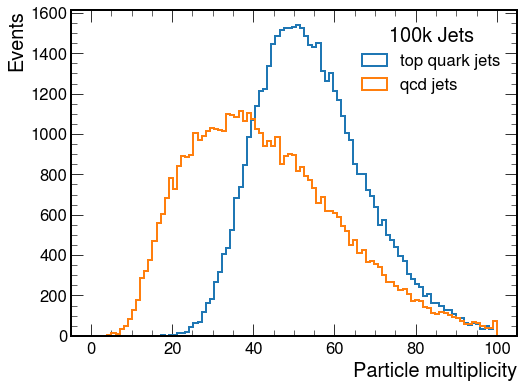

In [110]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(multiplicity["top"], bins=np.linspace(0,100,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(multiplicity["qcd"], bins=np.linspace(0,100,100), histtype="step", linewidth=2, label=f"qcd jets")

# ax.set_xlim(40,400)
# ax.set_ylim(0,0.4)
ax.legend(title="100k Jets")
ax.set_xlabel(r"Particle multiplicity");
ax.set_ylabel(r"Events");

# Input features

In [111]:
# check input features
features = {}

feature deltaR corresponding to index 6


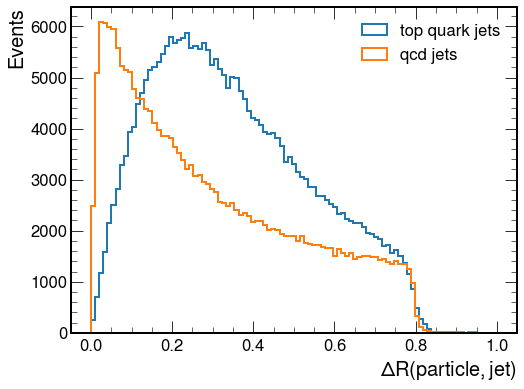

In [330]:
# which feature to look at?
feature = "deltaR"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet in tqdm(data_train[:10000]):
    if jet.y==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.x:
        features[label].append(particle[index])
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,1,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,1,100), histtype="step", linewidth=2, label=f"qcd jets")

# ax.set_xlim(40,400)
# ax.set_ylim(0,0.4)
ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events");            

feature eta corresponding to index 0


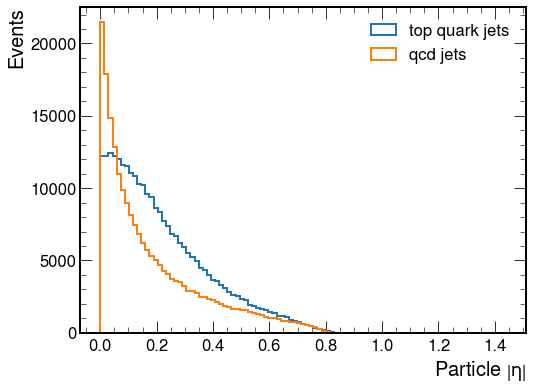

In [331]:
# which feature to look at?
feature = "eta"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet in tqdm(data_train[:10000]):
    if jet.y==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.x:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,1.44,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,1.44,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events");            

feature phi corresponding to index 1


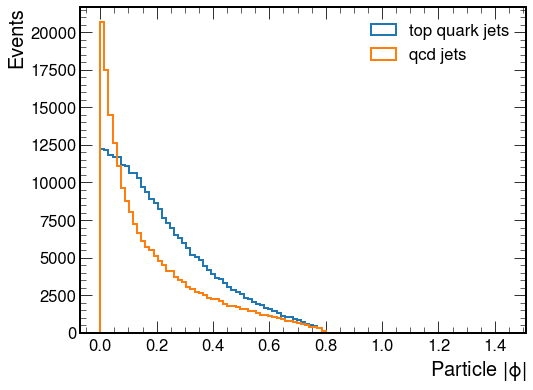

In [332]:
# which feature to look at?
feature = "phi"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet in tqdm(data_train[:10000]):
    if jet.y==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.x:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,1.44,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,1.44,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events");            

feature pt corresponding to index 2


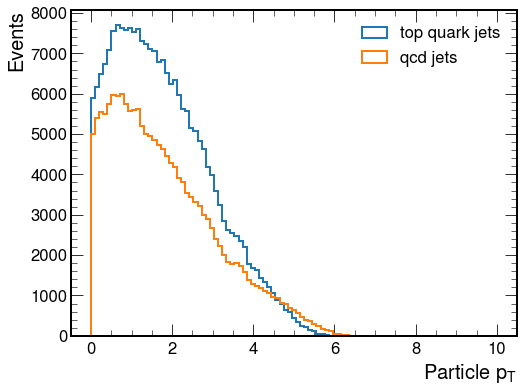

In [333]:
# which feature to look at?
feature = "pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet in tqdm(data_train[:10000]):
    if jet.y==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.x:
        features[label].append(particle[index])
           
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,10,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,10,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events");            

feature pt/jet_pt corresponding to index 4


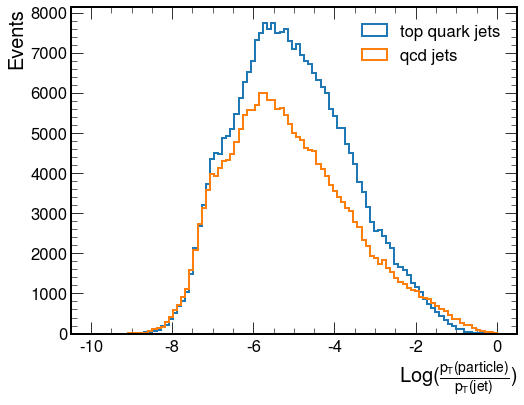

In [341]:
# which feature to look at?
feature = "pt/jet_pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet in tqdm(data_train[:10000]):
    if jet.y==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.x:
        features[label].append(particle[index])
           
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events");            

feature E/jet_E corresponding to index 5


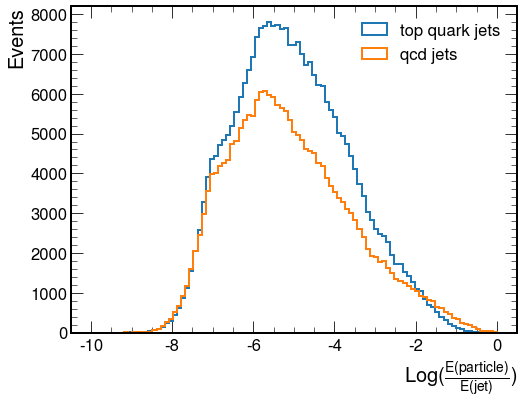

In [342]:
# which feature to look at?
feature = "E/jet_E"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet in tqdm(data_train[:10000]):
    if jet.y==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.x:
        features[label].append(particle[index])
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events");            

## Try to observe jet substructure

In [365]:
# look for the distribution of dR/distances between particles in jets
dists = {}
dists["top"] = []
dists["qcd"] = []

for jet in tqdm(data_train[:10000]):
    # dummy list of distances per jet that we will average over to get a single measure in the end
    l = []
    
    if jet.y==1:
        label = "top"
    else:
        label = "qcd"
        
    for ind_p in range(len(jet.x)):  # i_p stands for index of particle
        eta1 = jet.x[ind_p][feature_dict["eta"]]
        phi1 = jet.x[ind_p][feature_dict["phi"]]

        if ind_p < (len(jet.x)-1):
            for ind_n in range(ind_p+1, len(jet.x)):   # i_n stands for index of neighbor
                eta2 = jet.x[ind_n][feature_dict["eta"]]
                phi2 = jet.x[ind_n][feature_dict["phi"]]     
                
                deltaR = np.sqrt((eta1 - eta2)**2 + (phi1 - phi2)**2)
                
                l.append(np.round(deltaR.item(), decimals=4))
    
    dists[label].append(sum(l)/len(l))         

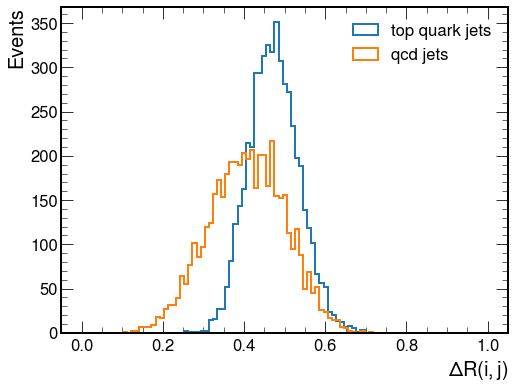

In [366]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(dists["top"], bins=np.linspace(0,1,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(dists["qcd"], bins=np.linspace(0,1,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(r"$\Delta R(i,j)$");
ax.set_ylabel(r"Events");   

# Plotting jets

In [367]:
def plot_jet(jet_index):
    plt.style.use(hep.style.CMS)
    plt.rcParams.update({'font.size': 20})

    jet_input = data_train[jet_index].x
    jet_label = data_train[jet_index].y
    if jet_label==1:
        print(f"Jet # {jet_index} is a top quark jet")
    else:
        print(f"Jet # {jet_index} is a qcd jet")

    print('Building the graph...')        
    pt = jet_input[:, feature_dict["pt"]].unsqueeze(1)
    eta = jet_input[:, feature_dict["eta"]].unsqueeze(1)
    phi = jet_input[:, feature_dict["phi"]].unsqueeze(1)
    eta_phi = torch.cat([eta, phi], axis=1)

    # get positions of nodes in the graph
    pos = {}
    num_nodes = len(jet_input)
    for node_i in range(num_nodes):
        pos[node_i] = eta_phi.numpy()[node_i]

    # plot nodes without connections
    print(f'Plotting the point cloud...')        
    fig, ax = plt.subplots(figsize=(10, 8))            
    ax.scatter(
        eta,
        phi,
        c=pt,
        cmap='Greys',
        norm=colors.LogNorm(vmin=0.001, vmax=0.1),
    )      

    plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    cbar = plt.colorbar()
#     cbar.set_label(r"$\frac{p_T(particle)}{p_T(jet)}$")
    cbar.set_label(r"$\frac{p_T}{p_T(jet)}$")

    plt.xlabel(r"$\Delta\eta$", fontsize=30) 
    plt.ylabel(r"$\Delta\phi$", fontsize=30) 

    plt.ylim(-0.8, 0.8)
    plt.xlim(-0.8, 0.8)
    ax.set_xticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])
    ax.set_yticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6]) 
    ax.tick_params(pad=10, left=True, bottom=True, labelleft=True, labelbottom=True)    
    ax.legend(title="Top quark jet" if jet_label==1 else "QCD jet", title_fontsize=25)
    # plt.savefig(f"/xai4hepvol/LRP/paper_plots/no_subjets_jet.pdf")    
    plt.show() 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Jet # 1 is a qcd jet
Building the graph...
Plotting the point cloud...


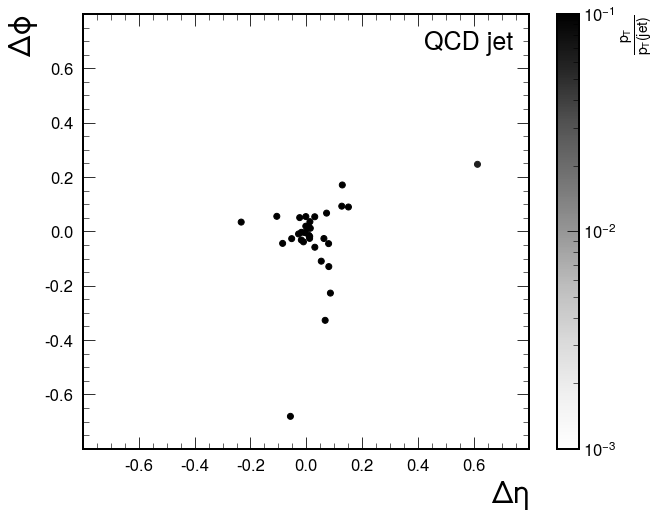

In [371]:
plot_jet(jet_index=1)